In [1]:
# Parameters
notebook_fname = "NN_full_v3_BO_test_9"
data_path = '../01_Dataset_Cleaned/'
model_path = '../04_Model_Saved/'

# Development mode: automatic reloading of modules
%load_ext autoreload
%autoreload 2


# main notebook to train and evaluate the machine learning model


In [2]:
import os
import sys
sys.path.append("..")
sys.path.append("../..")

current_directory = os.getcwd()
print("Current directory:", current_directory)

Current directory: /nethome/home3/yuxiang.wu/CCA_CALPHAD_SSS_ML/CCA_representation_ML/03_Model_Train_Evaluate_Predict


In [3]:
# basic machine learning libaries/Bayesian Optimization/Parellisation
import importlib
from tabulate import tabulate
import concurrent.futures
from joblib import Parallel, delayed
from multiprocessing import Pool
import GPyOpt
import os
import pickle
import time
import warnings
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Concatenate, Dropout, BatchNormalization
from keras.utils.vis_utils import plot_model

# Data processing and plotting
import numpy as np
from numpy import asarray
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.pyplot import figure
import matplotlib
matplotlib.rcParams['font.family'] = 'FreeSans'


# Miscellaneous
warnings.filterwarnings("ignore")
# Turn off TensorFlow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel('ERROR')

print(f'cpu_count: {os.cpu_count()}')

# Data Path
if os.path.isfile(data_path+'LiteratureDataset_Corrosion_YW_v3_processed.xlsx'):
    print(f"Folder '{os.path.abspath(data_path)}' found.")
else:
    print(f"Warning: File '{data_path}' not found!")

# Setting up multiple path for parallel Bayesian Optimization
num_str = notebook_fname.split("_")[-1]  # get the last string after "_"

try:
    bo_ens_num = int(num_str)
    print(f"bo_ens_num: {bo_ens_num}")
except ValueError:
    # if the string can't be converted to an integer, keep it as a string
    bo_ens_num = int(123)
    print(f"book master - bo_ens_num: {bo_ens_num}")

# model path
model_path_bo = f'{model_path}{notebook_fname}/'

if not os.path.exists(model_path_bo):
    os.makedirs(model_path_bo)
    print(f"Folder '{os.path.abspath(model_path_bo)}' created.")
else:
    print(f"Folder '{os.path.abspath(model_path_bo)}' already exists.")

# Cleaning up previous tensorflow sessions
tf.keras.backend.clear_session()

2023-11-14 23:19:27.337673: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-14 23:19:30.014283: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-11-14 23:19:30.014405: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-11-14 23:19:30.014412

cpu_count: 72
Folder '/nethome/home3/yuxiang.wu/CCA_CALPHAD_SSS_ML/CCA_representation_ML/01_Dataset_Cleaned' found.
bo_ens_num: 9
Folder '/nethome/home3/yuxiang.wu/CCA_CALPHAD_SSS_ML/CCA_representation_ML/04_Model_Saved/NN_full_v3_BO_test_9' already exists.


## functionality control


In [4]:
# functionality control of the notebook
Flag_Preprocessing = True
Flag_Training_try = True
Flag_BO_search = False
Flag_Training_BO_best = False
Flag_Evaluation = False
Flag_Prediction = False
Flag_Explainer = False

# Use GPU or not
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
print('not using GPU')

not using GPU


## Import hardness and corrosion dataset


In [5]:
# Declare column names for the chemical composition dataframe, specific testing conditions, selected features, and output for Hardness and Corrosion datasets.
compo_column = ['Fe', 'Cr', 'Ni', 'Mo', 'W', 'N', 'Nb', 'C', 'Si',
                'Mn', 'Cu', 'Al', 'V', 'Ta', 'Ti', 'Co', 'Mg', 'Y', 'Zr', 'Hf']
C_specific_testing_column = ['TestTemperature_C',
                             'ChlorideIonConcentration', 'pH', 'ScanRate_mVs']
specific_features_sel_column = ['delta_a', 'Tm', 'sigma_Tm',
                                'Hmix', 'sigma_Hmix', 'sigma_elec_nega', 'VEC', 'sigma_VEC']
H_output_column = ['converted HV']
C_output_column = ['AvgPittingPotential_mV']

# Load the Hardness and Corrosion datasets
df_H = pd.read_excel(
    data_path + 'LiteratureDataset_Hardness_YW_v3_processed.xlsx')
df_C = pd.read_excel(
    data_path + 'LiteratureDataset_Corrosion_YW_v3_processed.xlsx')

# Partition the datasets into component composition, specific features, and output data
df_H_compo, df_H_specific_testing, df_H_specific_features, df_H_output = df_H[compo_column], pd.DataFrame(), df_H[
    specific_features_sel_column],  df_H[H_output_column]
(df_C_compo, df_C_specific_testing, df_C_specific_features,
 df_C_output) = df_C[compo_column], df_C[C_specific_testing_column], df_C[specific_features_sel_column], df_C[C_output_column]

df_H_compo_specific_features = pd.concat(
    [df_H_compo, df_H_specific_features], axis=1)
df_C_compo_specific_features = pd.concat(
    [df_C_compo, df_C_specific_features], axis=1)

## Data preprocessing

**hardness network**

- input (X1): df_H_compo
- input (Y1): df_H_specific_testing
- input (V1): df_H_specific_features
- output(H1): df_H_output

**corrosion network**

- input (X2): df_C_compo
- input (Z2): df_C_specific_testing
- input (W2): df_C_specific_features
- output(C2): df_C_output

### Obtain the MinMaxScaler from normalisation


In [6]:
if Flag_Preprocessing:

    # Prepare data for NN
    dfs = [df_H_compo, df_H_specific_testing, df_H_specific_features, df_H_output,
           df_C_compo, df_C_specific_testing, df_C_specific_features, df_C_output]

    # Convert DataFrames to numpy arrays
    inputs_outputs = [np.asarray(df.values) for df in dfs]

    # Define each variable
    (X1, Y1, V1, H1,
     X2, Z2, W2, C2) = inputs_outputs

    # # Initialize MinMaxScalers for each data set
    # scalers = {
    #     "compo": MinMaxScaler(),
    #     "H_specific_testing": MinMaxScaler(),
    #     "C_specific_testing": MinMaxScaler(),
    #     "specific_features": MinMaxScaler(),
    #     "H_output": MinMaxScaler(),
    #     "C_output": MinMaxScaler()
    # }

    # Initialize StandardScaler for each data set
    scalers = {
        "compo": StandardScaler(),
        "H_specific_testing": StandardScaler(),
        "C_specific_testing": StandardScaler(),
        "specific_features": StandardScaler(),
        "H_output": StandardScaler(),
        "C_output": StandardScaler()
    }

    # Fit scalers to appropriate data
    scalers["compo"].fit(np.concatenate((X1, X2)))
    if Y1.size != 0:  # if Y1 is empty
        scalers["H_specific_testing"].fit(Y1)
    scalers["C_specific_testing"].fit(Z2)
    scalers["specific_features"].fit(np.concatenate((V1, W2)))
    scalers["H_output"].fit(H1.reshape((-1, 1)))
    scalers["C_output"].fit(C2.reshape((-1, 1)))

    # Save the scalers dictionary to a file using pickle
    with open(data_path + 'scalers.pkl', 'wb') as f:
        pickle.dump(scalers, f)

    print(scalers)

{'compo': StandardScaler(), 'H_specific_testing': StandardScaler(), 'C_specific_testing': StandardScaler(), 'specific_features': StandardScaler(), 'H_output': StandardScaler(), 'C_output': StandardScaler()}


### RepeatedKFold train-test split

- for hardness: `kfold_with_norm_H`

  - `X1_train_KFold`, `X1_test_KFold`,
  - (empty array)
  - `V1_train_KFold`, `V1_test_KFold`,
  - `H1_train_KFold`, `H1_test_KFold` as lists used in model training

- for corrosion: `kfold_with_norm_C`
  - `X2_train_KFold`, `X2_test_KFold`,
  - `Z2_train_KFold`, `Z2_test_KFold`,
  - `W2_train_KFold`, `W2_test_KFold`,
  - `C2_train_KFold`, `C2_test_KFold` as lists used in model training


In [7]:
if Flag_Preprocessing:

    from utils.preprocessing_kfold_norm import kfold_with_norm

    n_splits, n_repeats, random_state = 6, 2, 42

    # for hardness network
    ([X1_train_KFold, Y1_train_KFold, V1_train_KFold, H1_train_KFold],
     [X1_test_KFold, Y1_test_KFold, V1_test_KFold, H1_test_KFold],
     [X1_train_norm_KFold, Y1_train_norm_KFold,
         V1_train_norm_KFold, H1_train_norm_KFold],
     [X1_test_norm_KFold, Y1_test_norm_KFold, V1_test_norm_KFold, H1_test_norm_KFold]) = kfold_with_norm(X1, Y1, V1, H1,
                                                                                                         scalers["compo"], scalers["H_specific_testing"], scalers[
                                                                                                             "specific_features"], scalers["H_output"],
                                                                                                         n_splits, n_repeats, random_state)

    # for corrosion network
    ([X2_train_KFold, Z2_train_KFold, W2_train_KFold, C2_train_KFold],
     [X2_test_KFold, Z2_test_KFold, W2_test_KFold, C2_test_KFold],
     [X2_train_norm_KFold, Z2_train_norm_KFold,
         W2_train_norm_KFold, C2_train_norm_KFold],
     [X2_test_norm_KFold, Z2_test_norm_KFold, W2_test_norm_KFold, C2_test_norm_KFold]) = kfold_with_norm(X2, Z2, W2, C2,
                                                                                                         scalers["compo"], scalers["C_specific_testing"], scalers[
                                                                                                             "specific_features"], scalers["C_output"],
                                                                                                         n_splits, n_repeats, random_state)

### Plot the histogram of train/test data for each split

- Plotting hardness train/test datasets
- Plotting corrosion train/test datasets


In [8]:
# if Flag_Preprocessing:

#     from utils.preprocessing_kfold_norm import plot_hist_kfold_with_norm

#     # call the function to plot the histograms - hardness network
#     plot_hist_kfold_with_norm(train_data=(X1_train_norm_KFold, Y1_train_norm_KFold, V1_train_norm_KFold, H1_train_norm_KFold),
#                               test_data=(X1_test_norm_KFold, Y1_test_norm_KFold,
#                                          V1_test_norm_KFold,  H1_test_norm_KFold),
#                               # x_min=(0, 0, 0, 0),
#                               # x_max=(0.2, 0, 1, 1),
#                               x_min=(-3, -3, -3, -3),
#                               x_max=(3,  3,  3,  3),
#                               axs_title='Hardness network Train/Test Data',
#                               n_splits=6, n_repeats=1, nrows=4)

#     # call the function to plot the histograms - corrosion network
#     plot_hist_kfold_with_norm(train_data=(X2_train_norm_KFold, Z2_train_norm_KFold, W2_train_norm_KFold, C2_train_norm_KFold),
#                               test_data=(X2_test_norm_KFold,  Z2_test_norm_KFold,
#                                          W2_test_norm_KFold, C2_test_norm_KFold),
#                               # x_min=(0, 0, 0, 0),
#                               # x_max=(0.2, 1, 1, 1),
#                               x_min=(-3, -3, -3, -3),
#                               x_max=(3,  3,  3,  3),
#                               axs_title='Corrosion network Train/Test Data',
#                               n_splits=6, n_repeats=1, nrows=4)

## NN architecture, creation, evaluation:

- shared feature NN: NNS
- hardness NN: NNH
- corrosion NN: NNC

class: `MultiTaskNN`

```
         input2-->|
                  |-->[NNH]-->output_H
                  |
 input1-->[NNS]-->|
                  |
                  |-->[NNC]-->output_C
         input3-->|
```


### Using `MultiTaskNN` class for training


In [9]:
if Flag_Training_try:
    from concurrent.futures import ThreadPoolExecutor
    from utils.multitask_nn import MultiTaskNN, plot_R2_avg

    def create_multitask_nn(shared_layers):
        return MultiTaskNN(
            NNS_num_nodes=128, NNS_num_layers=2,
            NNH_num_nodes=64, NNH_num_layers=3,
            NNC_num_nodes=64, NNC_num_layers=3,
            mc_state=True, act='relu',
            NNS_dropout=0.25, NNH_dropout=0.25, NNC_dropout=0.25,
            loss_func=tf.keras.metrics.mean_squared_error,
            learning_rate_H=0.001, learning_rate_C=0.001,
            batch_size_H=32,
            N_epochs_local=1,
            total_epochs=250,
            model_save_flag=False,
            model_path_bo=model_path_bo,
            share_initial_layers=shared_layers,
            NNH_model_name='NNH_model_RepeatedKFold_{}',
            NNC_model_name='NNC_model_RepeatedKFold_{}'
        )

    def evaluate_model(mt_nn, *args):
        return mt_nn.evaluate_NN_full_model(*args)

    # Create MultiTaskNN instances
    mt_nn_shared = create_multitask_nn(shared_layers=True)
    mt_nn_separate = create_multitask_nn(shared_layers=False)

    # Inputs for `RepeatedKFold`
    k_folds, n_CVrepeats = 6, 2

    # Data for evaluation
    data_args = (X1_train_norm_KFold, X1_test_norm_KFold, Y1_train_norm_KFold, Y1_test_norm_KFold,
                 V1_train_norm_KFold, V1_test_norm_KFold, H1_train_norm_KFold, H1_test_norm_KFold,
                 X2_train_norm_KFold, X2_test_norm_KFold, Z2_train_norm_KFold, Z2_test_norm_KFold,
                 W2_train_norm_KFold, W2_test_norm_KFold, C2_train_norm_KFold, C2_test_norm_KFold)

    start_time = time.time()

    # Use ThreadPoolExecutor to parallelise
    with ThreadPoolExecutor(max_workers=2) as executor:
        future_shared = executor.submit(
            evaluate_model, mt_nn_shared, *data_args, k_folds, n_CVrepeats, scalers)
        future_separate = executor.submit(
            evaluate_model, mt_nn_separate, *data_args, k_folds, n_CVrepeats, scalers)

        results_shared = future_shared.result()
        results_separate = future_separate.result()

    elapsed_time = time.time() - start_time
    print(f"Time taken: {int(elapsed_time)} seconds")

    # Unpack results
    (train_loss_H_shared, train_loss_C_shared,
     val_loss_H_shared, val_loss_C_shared,
     score_loss_H_shared, score_loss_C_shared,
     score_r2_H_shared, score_r2_C_shared) = results_shared

    (train_loss_H_separate, train_loss_C_separate,
     val_loss_H_separate, val_loss_C_separate,
     score_loss_H_separate, score_loss_C_separate,
     score_r2_H_separate, score_r2_C_separate) = results_separate

### Training quality for NNH_model and NNC_model


In [10]:
if Flag_Training_try:
    from utils.multitask_nn import plot_R2_avg
    # training results by score_loss
    print('-----')
    # print([f'{x:.4f}' for x in score_loss_H_shared])
    # print([f'{x:.4f}' for i in range(12) for x in val_loss_H_shared[i][-1]])
    print(
        f"score_loss_H_shared: {np.mean(score_loss_H_shared):.4f} ({np.std(score_loss_H_shared):.4f})")
    print(
        f"score_loss_H_separate: {np.mean(score_loss_H_separate):.4f} ({np.std(score_loss_H_separate):.4f})")

    print('-----')
    # print([f'{x:.4f}' for x in score_loss_C_shared])
    # print([f'{x:.4f}' for i in range(12) for x in val_loss_C_shared[i][-1]])
    print(
        f"score_loss_C_shared: {np.mean(score_loss_C_shared):.4f} ({np.std(score_loss_C_shared):.4f})")
    print(
        f"score_loss_C_separate: {np.mean(score_loss_C_separate):.4f} ({np.std(score_loss_C_separate):.4f})")

    # training results by score_r2
    print('-----')
    # print([f'{x:.4f}' for x in score_r2_H_shared])
    print(
        f"score_r2_H_shared: {np.mean(score_r2_H_shared):.4f} ({np.std(score_r2_H_shared):.4f})")
    print(
        f"score_r2_H_separate: {np.mean(score_r2_H_separate):.4f} ({np.std(score_r2_H_separate):.4f})")

    print('-----')
    # print([f'{x:.4f}' for x in score_r2_C_shared])
    print(
        f"score_r2_C_shared: {np.mean(score_r2_C_shared):.4f} ({np.std(score_r2_C_shared):.4f})")
    print(
        f"score_r2_C_separate: {np.mean(score_r2_C_separate):.4f} ({np.std(score_r2_C_separate):.4f})")

    print('-----')
    print(
        f"score_r2_HC_shared: {np.mean([score_r2_H_shared, score_r2_C_shared]):.4f} ({np.std([score_r2_H_shared, score_r2_C_shared]):.4f})")
    print(
        f"score_r2_HC_separate: {np.mean([score_r2_H_separate, score_r2_C_separate]):.4f} ({np.std([score_r2_H_separate, score_r2_C_separate]):.4f})")

    # plot the R2 comparison
    H_list = [score_r2_H_shared, score_r2_H_separate]
    C_list = [score_r2_C_shared, score_r2_C_separate]

    plot_R2_avg(model_path_bo,
                H_list, C_list,
                ymin=0.5, ymax=0.85,
                x_labels=['multi-task\nlearning (MTL)', 'separate\nlearning'],
                savefig=False, figname='xNN_full_RepeatedKFold_R2_compare.pdf')

### Plot the loss history


In [11]:
if Flag_Training_try:
    from utils.multitask_nn import plot_losses_avg
    plot_losses_avg(model_path_bo, train_loss_H_shared, val_loss_H_shared,
                    train_loss_C_shared, val_loss_C_shared,
                    k_folds=6, n_CVrepeats=2, index=0, ymax=0.8, window_size=5,
                    savefig=False, figname='NN_full_RepeatedKFold_loss_shared.pdf')
    plot_losses_avg(model_path_bo, train_loss_H_separate, val_loss_H_separate,
                    train_loss_C_separate, val_loss_C_separate,
                    k_folds=6, n_CVrepeats=2, index=0, ymax=0.8, window_size=5,
                    savefig=False, figname='NN_full_RepeatedKFold_loss_separate.pdf')

## Bayesian Hyperparameter Optimisation

class: `BO_hyper_objective`


### Define the search domain


In [12]:
if Flag_BO_search:
    # Define the search space for hyperparameters

    # loss_encoder == 0: mean_squared_error
    # loss_encoder == 1: mean_absolute_error

    search_hyper_space = [{'name': 'NNS_num_nodes',   'type': 'discrete',  'domain': (32, 64, 128, 256)},  # 0: NNS_num_nodes
                          {'name': 'NNS_num_layers',  'type': 'discrete',
                           'domain': (1, 2, 3, 4, 5)},  # 1: NNS_num_layers
                          {'name': 'NNH_num_nodes',   'type': 'discrete',
                           'domain': (32, 64, 128)},    # 2: NNH_num_nodes
                          {'name': 'NNH_num_layers',  'type': 'discrete',
                           'domain': (1, 2, 3)},        # 3: NNH_num_layers
                          {'name': 'NNC_num_nodes',   'type': 'discrete',
                           'domain': (32, 64, 128)},    # 4: NNC_num_nodes
                          {'name': 'NNC_num_layers',  'type': 'discrete',
                           'domain': (1, 2, 3)},        # 5: NNC_num_layers
                          {'name': 'learning_rate_H', 'type': 'continuous',
                           'domain': (0.0001, 0.0005)},    # 9: learning_rate_H
                          {'name': 'learning_rate_C', 'type': 'continuous',
                           'domain': (0.0001, 0.0005)},    # 10: learning_rate_C
                          {'name': 'batch_size_H',    'type': 'discrete',
                           'domain': (16, 32, 64)},        # 11: batch_size_H
                          {'name': 'N_epochs_local',  'type': 'discrete',  'domain': (1, 2, 3)}]  # 12: N_epochs_global

    fixed_hyper_space = [{'name': 'NNS_dropout',     'type': 'continuous',
                          'domain': (0.1)},            # 6: NNS_dropout
                         {'name': 'NNH_NNC_dropout', 'type': 'continuous',
                          'domain': (0.1)},            # 7: NNH_NNC_dropout
                         {'name': 'loss_encoder',      'type': 'discrete',
                          'domain': (0)}]               # 8: loss_encoder

    search_hyper_names = [entry['name'] for entry in search_hyper_space]
    fixed_hyper_names = [entry['name'] for entry in fixed_hyper_space]
    all_hyper_names = ['NNS_num_nodes', 'NNS_num_layers', 'NNH_num_nodes', 'NNH_num_layers', 'NNC_num_nodes', 'NNC_num_layers',
                       'NNS_dropout', 'NNH_NNC_dropout',  'loss_encoder', 'learning_rate_H',  'learning_rate_C',   'batch_size_H', 'N_epochs_local']

### BO hyperparameter optimisation


In [13]:
if Flag_BO_search:
    from utils.BO_hyper_objective import BayesianOptimizationObjective

    start_time = time.time()

    # Set up the optimizer
    bo = None
    bo_iteration = 0
    np.random.seed(bo_ens_num)

    # Configuration settings for the model being optimized
    total_epochs = 10
    n_initial_points, n_iterations = 1, 1

    mc_state, act = True, 'relu'
    model_save_flag = False
    share_initial_layers = True
    NNH_model_name, NNC_model_name = 'NNH_model_RepeatedKFold_{}', 'NNC_model_RepeatedKFold_{}'
    k_folds, n_CVrepeats = 6, 2
    (score_r2_HC_list, score_loss_HC_list,
     score_r2_H_list, score_r2_C_list,
     score_loss_H_list, score_loss_C_list) = [], [], [], [], [], []

    # Instantiate the objective function class for Bayesian Optimization
    bo_obj = BayesianOptimizationObjective(
        bo_ens_num, model_path_bo, all_hyper_names, search_hyper_names)

    # Set up and configure Bayesian Optimization using GPyOpt
    bo = GPyOpt.methods.BayesianOptimization(f=lambda x: bo_obj.BO_NNS_NNH_NNC_objective(x, fixed_hyper_space, search_hyper_names, fixed_hyper_names,
                                                                                         n_initial_points, n_iterations,
                                                                                         mc_state, act,
                                                                                         total_epochs,
                                                                                         model_save_flag, model_path_bo,
                                                                                         share_initial_layers,
                                                                                         NNH_model_name, NNC_model_name,
                                                                                         X1_train_norm_KFold, X1_test_norm_KFold, Y1_train_norm_KFold, Y1_test_norm_KFold, V1_train_norm_KFold, V1_test_norm_KFold, H1_train_norm_KFold, H1_test_norm_KFold,
                                                                                         X2_train_norm_KFold, X2_test_norm_KFold, Z2_train_norm_KFold, Z2_test_norm_KFold, W2_train_norm_KFold, W2_test_norm_KFold, C2_train_norm_KFold, C2_test_norm_KFold,
                                                                                         k_folds, n_CVrepeats,
                                                                                         score_r2_HC_list, score_loss_HC_list,
                                                                                         score_r2_H_list, score_r2_C_list,
                                                                                         score_loss_H_list, score_loss_C_list)[0],  # Use only score_r2 as objective function
                                             domain=search_hyper_space,
                                             model_type='GP',
                                             initial_design_numdata=n_initial_points,
                                             init_design_type='random',
                                             acquisition_type='EI',
                                             acquisition_optimizer_type='lbfgs',
                                             maximize=True)

    # Start the optimization for the given number of iterations
    bo.run_optimization(max_iter=n_iterations)

    # Print the best hyperparameters and their corresponding objective value
    best_hyperparameters = ", ".join("{:.4f}".format(h) for h in bo.x_opt)
    print("Best hyperparameters: {}".format(best_hyperparameters))
    print("Best objective value:", -bo.fx_opt)

    # Calculate and display the elapsed time for the optimization
    elapsed_time = time.time() - start_time
    print("Time taken: ", int(elapsed_time), "seconds")

### Save the BO hypertable


In [14]:
if Flag_BO_search:

    # update the hypertable
    bo_obj.update_hypertable(fixed_hyper_space, bo,
                             score_r2_HC_list, score_loss_HC_list,
                             score_r2_H_list, score_r2_C_list, score_loss_H_list, score_loss_C_list)

    # Save the sorted data to an Excel file
    bo_obj.hypertable.to_excel(model_path_bo +
                               f"hypertable_{notebook_fname}.xlsx", index=False)

    # sort the list start from the best results
    hypertable_sort = bo_obj.hypertable.sort_values(
        by=['score_r2_HC'], ascending=False, ignore_index=True)

    display(hypertable_sort.head())

    # Save the sorted data to an Excel file
    hypertable_sort.to_excel(model_path_bo +
                             f"hypertable_sort_{notebook_fname}.xlsx", index=False)

### Plotting the BO process


In [15]:
if Flag_BO_search:
    # plot the convergence
    bo.plot_convergence()

    bo_obj.plot_best_r2_score()

## Model training: using best BO hyperparameters


In [16]:
if Flag_Training_BO_best:

    import tensorflow as tf
    import pandas as pd
    from utils.multitask_nn import MultiTaskNN

    def get_hyperparameter(param_name, hypertable):
        return hypertable.loc[0, param_name]

    def create_multi_task_nn(mc_state, act, total_epochs, share_initial_layers,
                             NNH_model_name, NNC_model_name, hypertable):
        # Define loss encoders
        loss_encoders = {
            0: tf.keras.metrics.mean_squared_error,
            1: tf.keras.metrics.mean_absolute_error
        }
        loss_encoder = int(get_hyperparameter('loss_encoder', hypertable))
        loss_func = loss_encoders.get(loss_encoder)
        if not loss_func:
            raise ValueError(f"Invalid loss function '{loss_encoder}' ")

        # Define parameters
        params = {
            'NNS_num_nodes': int(get_hyperparameter('NNS_num_nodes', hypertable)),
            'NNS_num_layers': int(get_hyperparameter('NNS_num_layers', hypertable)),
            'NNH_num_nodes': int(get_hyperparameter('NNH_num_nodes', hypertable)),
            'NNH_num_layers': int(get_hyperparameter('NNH_num_layers', hypertable)),
            'NNC_num_nodes': int(get_hyperparameter('NNC_num_nodes', hypertable)),
            'NNC_num_layers': int(get_hyperparameter('NNC_num_layers', hypertable)),
            'mc_state': mc_state,
            'act': act,
            'NNS_dropout': get_hyperparameter('NNS_dropout', hypertable),
            'NNH_dropout': get_hyperparameter('NNH_NNC_dropout', hypertable),
            'NNC_dropout': get_hyperparameter('NNH_NNC_dropout', hypertable),
            'loss_func': loss_func,
            'learning_rate_H': get_hyperparameter('learning_rate_H', hypertable),
            'learning_rate_C': get_hyperparameter('learning_rate_C', hypertable),
            'batch_size_H': int(get_hyperparameter('batch_size_H', hypertable)),
            'N_epochs_local': int(get_hyperparameter('N_epochs_local', hypertable)),
            'total_epochs': total_epochs,
            'model_save_flag': True,
            'model_path_bo': model_path_bo,
            'share_initial_layers': share_initial_layers,
            'NNH_model_name': NNH_model_name,
            'NNC_model_name': NNC_model_name
        }

        return MultiTaskNN(**params)

### Parallelsed training for best BO hyperparameters


In [17]:
if Flag_Training_BO_best:

    start_time = time.time()

    # ---------- loading the best BO hyperparameters ----------
    hypertable_sort = pd.read_excel(
        model_path_bo + f"hypertable_sort_{notebook_fname}.xlsx")
    hypertable_BObest = hypertable_sort.head(1)
    display(hypertable_BObest)
    k_folds, n_CVrepeats = 6, 2
    total_epochs = 500

    # ---------- creating models ----------
    # BObest MODEL with MC dropout + shared layers for uncertainty quantification
    mt_nn_BObest_mc_shared = create_multi_task_nn(mc_state=True, act='relu', total_epochs=total_epochs, share_initial_layers=True,
                                                  NNH_model_name='NNH_model_RepeatedKFold_{}_mc_shared_{act}',
                                                  NNC_model_name='NNC_model_RepeatedKFold_{}_mc_shared_{act}',
                                                  hypertable=hypertable_BObest)

    # BObest MODEL with MC dropout, but without shared layers to compare the architecture
    mt_nn_BObest_mc_separate = create_multi_task_nn(mc_state=True, act='relu', total_epochs=total_epochs, share_initial_layers=False,
                                                    NNH_model_name='NNH_model_RepeatedKFold_{}_mc_separate_{act}',
                                                    NNC_model_name='NNC_model_RepeatedKFold_{}_mc_separate_{act}',
                                                    hypertable=hypertable_BObest)

    # BObest MODEL without MC dropout and remove engineered feature to show the performance degradation
    mt_nn_BObest_mc_NoEng = create_multi_task_nn(mc_state=True, act='relu', total_epochs=total_epochs, share_initial_layers=True,
                                                 NNH_model_name='NNH_model_RepeatedKFold_{}_mc_NoEng_{act}',
                                                 NNC_model_name='NNC_model_RepeatedKFold_{}_mc_NoEng_{act}',
                                                 hypertable=hypertable_BObest)

    # Best model with only compositional input to simplify feature interaction analysis
    mt_nn_BObest_compo_XAI = create_multi_task_nn(mc_state=False, act='swish', total_epochs=total_epochs, share_initial_layers=True,
                                                  NNH_model_name='NNH_model_RepeatedKFold_{}_compo_XAI_{act}',
                                                  NNC_model_name='NNC_model_RepeatedKFold_{}_compo_XAI_{act}',
                                                  hypertable=hypertable_BObest)

    # Best model with compo-engineered features to check the compo-engineered features interaction
    mt_nn_BObest_compo_features_XAI = create_multi_task_nn(mc_state=False, act='swish', total_epochs=total_epochs, share_initial_layers=True,
                                                           NNH_model_name='NNH_model_RepeatedKFold_{}_compo_features_XAI_{act}',
                                                           NNC_model_name='NNC_model_RepeatedKFold_{}_compo_features_XAI_{act}',
                                                           hypertable=hypertable_BObest)

    # ---------- Helpful function to control inputs  ----------
    # Function to create empty arrays for datasets
    def create_empty_arrays(arr_list):
        return [np.empty((arr.shape[0], 0)) for arr in arr_list]

    # Helper function to evaluate the model
    def evaluate_model(model):
        return model.evaluate_NN_full_model(
            X1_train_norm_KFold, X1_test_norm_KFold, Y1_train_norm_KFold, Y1_test_norm_KFold, V1_train_norm_KFold, V1_test_norm_KFold, H1_train_norm_KFold, H1_test_norm_KFold,
            X2_train_norm_KFold, X2_test_norm_KFold, Z2_train_norm_KFold, Z2_test_norm_KFold, W2_train_norm_KFold, W2_test_norm_KFold, C2_train_norm_KFold, C2_test_norm_KFold,
            k_folds, n_CVrepeats, scalers)

    # Helper function to evaluate the model, but replace the testing and feature inputs to be empty

    def evaluate_model_compo_testing(model):

        datasets = [V1_train_norm_KFold, V1_test_norm_KFold,
                    W2_train_norm_KFold, W2_test_norm_KFold]

        V1_train_empty, V1_test_empty, \
            W2_train_empty, W2_test_empty = map(
                create_empty_arrays, datasets)

        return model.evaluate_NN_full_model(
            X1_train_norm_KFold, X1_test_norm_KFold, Y1_train_norm_KFold, Y1_test_norm_KFold, V1_train_empty, V1_test_empty, H1_train_norm_KFold, H1_test_norm_KFold,
            X2_train_norm_KFold, X2_test_norm_KFold, Z2_train_norm_KFold, Z2_test_norm_KFold, W2_train_empty, W2_test_empty, C2_train_norm_KFold, C2_test_norm_KFold,
            k_folds, n_CVrepeats, scalers)

    # Helper function to evaluate the model, but replace the testing and feature inputs to be empty
    def evaluate_model_compoOnly(model):

        datasets = [Y1_train_norm_KFold, Y1_test_norm_KFold, V1_train_norm_KFold, V1_test_norm_KFold,
                    Z2_train_norm_KFold, Z2_test_norm_KFold, W2_train_norm_KFold, W2_test_norm_KFold]

        Y1_train_empty, Y1_test_empty, V1_train_empty, V1_test_empty, \
            Z2_train_empty, Z2_test_empty, W2_train_empty, W2_test_empty = map(
                create_empty_arrays, datasets)

        return model.evaluate_NN_full_model(
            X1_train_norm_KFold, X1_test_norm_KFold, Y1_train_empty, Y1_test_empty, V1_train_empty, V1_test_empty, H1_train_norm_KFold, H1_test_norm_KFold,
            X2_train_norm_KFold, X2_test_norm_KFold, Z2_train_empty, Z2_test_empty, W2_train_empty, W2_test_empty, C2_train_norm_KFold, C2_test_norm_KFold,
            k_folds, n_CVrepeats, scalers)

    # Helper function to evaluate the model, but replace the testing and feature inputs to be empty

    def evaluate_model_compo_features(model):

        datasets = [Y1_train_norm_KFold, Y1_test_norm_KFold,
                    Z2_train_norm_KFold, Z2_test_norm_KFold]

        Y1_train_empty, Y1_test_empty, \
            Z2_train_empty, Z2_test_empty = map(
                create_empty_arrays, datasets)

        return model.evaluate_NN_full_model(
            X1_train_norm_KFold, X1_test_norm_KFold, Y1_train_empty, Y1_test_empty, V1_train_norm_KFold, V1_test_norm_KFold, H1_train_norm_KFold, H1_test_norm_KFold,
            X2_train_norm_KFold, X2_test_norm_KFold, Z2_train_empty, Z2_test_empty, W2_train_norm_KFold, W2_test_norm_KFold, C2_train_norm_KFold, C2_test_norm_KFold,
            k_folds, n_CVrepeats, scalers)

    # ---------- model training in parallel ----------
    # Using ProcessPoolExecutor to run in parallel
    futures_dict = {}
    with concurrent.futures.ProcessPoolExecutor() as executor:
        futures_dict['mc_shared'] = executor.submit(
            evaluate_model, mt_nn_BObest_mc_shared)
        futures_dict['mc_separate'] = executor.submit(
            evaluate_model, mt_nn_BObest_mc_separate)
        futures_dict['mc_NoEng'] = executor.submit(
            evaluate_model_compo_testing, mt_nn_BObest_mc_NoEng)
        futures_dict['compo_XAI'] = executor.submit(
            evaluate_model_compoOnly, mt_nn_BObest_compo_XAI)
        futures_dict['compo_features_XAI'] = executor.submit(
            evaluate_model_compo_features, mt_nn_BObest_compo_features_XAI)

    # Collecting results in the correct order
    results = {}
    for key in futures_dict:
        results[key] = futures_dict[key].result()

    # Unpack results as needed
    (train_loss_H_mc_shared, train_loss_C_mc_shared,
     val_loss_H_mc_shared, val_loss_C_mc_shared,
     score_loss_H_mc_shared, score_loss_C_mc_shared,
     score_r2_H_mc_shared, score_r2_C_mc_shared) = results['mc_shared']

    (train_loss_H_mc_separate, train_loss_C_mc_separate,
     val_loss_H_mc_separate, val_loss_C_mc_separate,
     score_loss_H_mc_separate, score_loss_C_mc_separate,
     score_r2_H_mc_separate, score_r2_C_mc_separate) = results['mc_separate']

    (train_loss_H_mc_NoEng, train_loss_C_mc_NoEng,
     val_loss_H_mc_NoEng, val_loss_C_mc_NoEng,
     score_loss_H_mc_NoEng, score_loss_C_mc_NoEng,
     score_r2_H_mc_NoEng, score_r2_C_mc_NoEng) = results['mc_NoEng']

    (train_loss_H_compo_XAI, train_loss_C_compo_XAI,
     val_loss_H_compo_XAI, val_loss_C_compo_XAI,
     score_loss_H_compo_XAI, score_loss_C_compo_XAI,
     score_r2_H_compo_XAI, score_r2_C_compo_XAI) = results['compo_XAI']

    (train_loss_H_compo_features_XAI, train_loss_C_compo_features_XAI,
     val_loss_H_compo_features_XAI, val_loss_C_compo_features_XAI,
     score_loss_H_compo_features_XAI, score_loss_C_compo_features_XAI,
     score_r2_H_compo_features_XAI, score_r2_C_compo_features_XAI) = results['compo_features_XAI']

    # Save all the parameters as BestBO
    # Save with pickle
    with open(model_path_bo + 'BObest_training_results.pkl', 'wb') as file:
        pickle.dump(results, file)

    # Print elapsed time
    elapsed_time = time.time() - start_time
    print("Time taken: ", int(elapsed_time), "seconds")

In [18]:
if Flag_Training_BO_best:

    from utils.multitask_nn import plot_losses_avg, plot_R2_avg
    model_results = {
        'mc_shared': (score_r2_H_mc_shared, score_r2_C_mc_shared),
        'mc_separate': (score_r2_H_mc_separate, score_r2_C_mc_separate),
        'mc_NoEng': (score_r2_H_mc_NoEng, score_r2_C_mc_NoEng),
        'compo_XAI': (score_r2_H_compo_XAI, score_r2_C_compo_XAI),
        'compo_features_XAI': (score_r2_H_compo_features_XAI, score_r2_C_compo_features_XAI)
    }

    for model_name, scores in model_results.items():
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        print(f"score_r2_HC_{model_name}: {mean_score:.4f} ({std_score:.4f})")

    plot_losses_avg(model_path_bo, train_loss_H_mc_shared, val_loss_H_mc_shared,
                    train_loss_C_mc_shared, val_loss_C_mc_shared,
                    k_folds=6, n_CVrepeats=2, index=0, ymax=0.8, window_size=1,
                    savefig=True, figname='NN_full_RepeatedKFold_loss_mc_shared.pdf')

    plot_losses_avg(model_path_bo, train_loss_H_mc_separate, val_loss_H_mc_separate,
                    train_loss_C_mc_separate, val_loss_C_mc_separate,
                    k_folds=6, n_CVrepeats=2, index=0, ymax=0.8, window_size=1,
                    savefig=True, figname='NN_full_RepeatedKFold_loss_Nomc_separate.pdf')

    H_list = [score_r2_H_mc_shared,
              score_r2_H_mc_separate, score_r2_H_mc_NoEng]
    C_list = [score_r2_C_mc_shared,
              score_r2_C_mc_separate, score_r2_C_mc_NoEng]

    plot_R2_avg(model_path_bo,
                H_list, C_list,
                ymin=0.6, ymax=0.85,
                x_labels=['multi-task\nlearning (MTL)',
                          'separate\nlearning', 'MTL without\nfeature\nengineering'],
                savefig=False, figname='xNN_full_RepeatedKFold_R2_compare.pdf')

In [19]:
if Flag_Training_BO_best:

    plot_losses_avg(model_path_bo, train_loss_H_compo_XAI, val_loss_H_compo_XAI,
                    train_loss_C_compo_XAI, val_loss_C_compo_XAI,
                    k_folds=6, n_CVrepeats=2, index=0, ymax=0.8, window_size=1,
                    savefig=False, figname='NA')

    plot_losses_avg(model_path_bo, train_loss_H_compo_features_XAI, val_loss_H_compo_features_XAI,
                    train_loss_C_compo_features_XAI, val_loss_C_compo_features_XAI,
                    k_folds=6, n_CVrepeats=2, index=0, ymax=0.8, window_size=1,
                    savefig=False, figname='NA')

## Evaluate the training results

- Show the model.h5 files in this directory
- Load scalers


In [20]:
import pickle
from utils.postprocessing_evalutation import display_saved_models

print(os.path.abspath(model_path_bo))

NNH_model_name = 'NNH_model_RepeatedKFold_{}_mc_shared_{act}.h5'
NNC_model_name = 'NNC_model_RepeatedKFold_{}_mc_shared_{act}.h5'
display_saved_models(model_path_bo, NNH_model_name,
                     NNC_model_name,  act='relu')

NNH_model_name = 'NNH_model_RepeatedKFold_{}_mc_separate_{act}.h5'
NNC_model_name = 'NNC_model_RepeatedKFold_{}_mc_separate_{act}.h5'
display_saved_models(model_path_bo, NNH_model_name,
                     NNC_model_name,  act='relu')

NNH_model_name = 'NNH_model_RepeatedKFold_{}_mc_NoEng_{act}.h5'
NNC_model_name = 'NNC_model_RepeatedKFold_{}_mc_NoEng_{act}.h5'
display_saved_models(model_path_bo, NNH_model_name,
                     NNC_model_name,  act='relu')

NNH_model_name = 'NNH_model_RepeatedKFold_{}_compo_XAI_{act}.h5'
NNC_model_name = 'NNC_model_RepeatedKFold_{}_compo_XAI_{act}.h5'
display_saved_models(model_path_bo, NNH_model_name,
                     NNC_model_name,  act='swish')

NNH_model_name = 'NNH_model_RepeatedKFold_{}_compo_features_XAI_{act}.h5'
NNC_model_name = 'NNC_model_RepeatedKFold_{}_compo_features_XAI_{act}.h5'
display_saved_models(model_path_bo, NNH_model_name,
                     NNC_model_name,  act='swish')

# Load the scalers dictionary from a file using pickle
with open(data_path + 'scalers.pkl', 'rb') as f:
    scalers = pickle.load(f)
    print("")
print(scalers)

/nethome/home3/yuxiang.wu/CCA_CALPHAD_SSS_ML/CCA_representation_ML/04_Model_Saved/NN_full_v3_BO_test_9

NNH_model_RepeatedKFold_Index_mc_shared_relu.h5    NNC_model_RepeatedKFold_Index_mc_shared_relu.h5
-------------------------------------------------  -------------------------------------------------
NNH_model_RepeatedKFold_1_mc_shared_relu.h5        NNC_model_RepeatedKFold_1_mc_shared_relu.h5
NNH_model_RepeatedKFold_2_mc_shared_relu.h5        NNC_model_RepeatedKFold_2_mc_shared_relu.h5
NNH_model_RepeatedKFold_3_mc_shared_relu.h5        NNC_model_RepeatedKFold_3_mc_shared_relu.h5
NNH_model_RepeatedKFold_4_mc_shared_relu.h5        NNC_model_RepeatedKFold_4_mc_shared_relu.h5
NNH_model_RepeatedKFold_5_mc_shared_relu.h5        NNC_model_RepeatedKFold_5_mc_shared_relu.h5
NNH_model_RepeatedKFold_6_mc_shared_relu.h5        NNC_model_RepeatedKFold_6_mc_shared_relu.h5
NNH_model_RepeatedKFold_7_mc_shared_relu.h5        NNC_model_RepeatedKFold_7_mc_shared_relu.h5
NNH_model_RepeatedKFold_8_mc_sh

### Plot true vs predictions (test data) for each RepeatedKFold


In [21]:
if Flag_Evaluation:
    from utils.postprocessing_evalutation import prepare_data_for_eval, predict_bootstrap, plot_test_true_vs_pred
    import concurrent.futures

    # Define a common function for the repeated processes

    def evaluate_model(model_suffix, iscompo_testing, iscompoOnly, iscompo_features, mc_repeat=1, plot_flag=False):
        NNH_model_name = f'NNH_model_RepeatedKFold_{{}}_{model_suffix}.h5'
        NNC_model_name = f'NNC_model_RepeatedKFold_{{}}_{model_suffix}.h5'
        k_folds, n_CVrepeats = 6, 2

        # Prepare data for evaluation
        (X1_test_list, Y1_test_list, V1_test_list,
         X2_test_list, Z2_test_list, W2_test_list,
         X1_list, Y1_list, V1_list,
         X2_list, Z2_list, W2_list) = prepare_data_for_eval(
            X1, Y1, V1, X2, Z2, W2,
            X1_test_KFold, Y1_test_KFold, V1_test_KFold,
            X2_test_KFold, Z2_test_KFold, W2_test_KFold,
            k_folds, n_CVrepeats,
            iscompo_testing, iscompoOnly, iscompo_features)

        with concurrent.futures.ThreadPoolExecutor() as executor:
            future1 = executor.submit(predict_bootstrap, model_path_bo, NNH_model_name,
                                      X1_test_list, Y1_test_list, V1_test_list,
                                      k_folds, n_CVrepeats, mc_repeat,
                                      scalers["compo"], scalers["H_specific_testing"],
                                      scalers["specific_features"], scalers["H_output"])

            future2 = executor.submit(predict_bootstrap, model_path_bo, NNC_model_name,
                                      X2_test_list, Z2_test_list, W2_test_list,
                                      k_folds, n_CVrepeats, mc_repeat,
                                      scalers["compo"], scalers["C_specific_testing"],
                                      scalers["specific_features"], scalers["C_output"])

        H1_test_pred_X1_stack, H1_test_pred_X1_mean, H1_test_pred_X1_std = future1.result()
        C2_test_pred_X2_stack, C2_test_pred_X2_mean, C2_test_pred_X2_std = future2.result()

        plt_score_r2_H = plot_test_true_vs_pred(k_folds, n_CVrepeats,
                                                H1_test_KFold, H1_test_pred_X1_mean, H1_test_pred_X1_std,
                                                [0, 1200], 'NNH', 'firebrick', model_path_bo, plot_flag,
                                                figname=f'NNH_RepeatedKFold_True_Prediction_testdata_{model_suffix}')

        plt_score_r2_C = plot_test_true_vs_pred(k_folds, n_CVrepeats,
                                                C2_test_KFold, C2_test_pred_X2_mean, C2_test_pred_X2_std,
                                                [-800, 1200], 'NNC', 'steelblue', model_path_bo, plot_flag,
                                                figname=f'NNC_RepeatedKFold_True_Prediction_testdata_{model_suffix}')

        return plt_score_r2_H, plt_score_r2_C

    # Define different configurations for evaluation
    configurations = [
        ("mc_shared_relu", False, False, False, 50, False),
        ("mc_separate_relu", False, False, False, 50, False),
        ("mc_NoEng_relu", True, False, False, 50, False)
    ]

    # Execute evaluation for each configuration
    results = {}
    for model_suffix, iscomp_testing, iscompOnly, iscomp_features, mc_repeats, plot_flag in configurations:
        results[f'plt_score_r2_H_{model_suffix}'], results[f'plt_score_r2_C_{model_suffix}'] = evaluate_model(
            model_suffix, iscomp_testing, iscompOnly, iscomp_features, mc_repeats, plot_flag)

    # results now contains all your plot variables like plt_score_r2_H_Nomc_separate etc.

In [22]:
if Flag_Evaluation:
    from utils.multitask_nn import plot_R2_avg

    H_list = [results['plt_score_r2_H_mc_shared_relu'],
              results['plt_score_r2_H_mc_separate_relu'], results['plt_score_r2_H_mc_NoEng_relu']]
    C_list = [results['plt_score_r2_C_mc_shared_relu'],
              results['plt_score_r2_C_mc_separate_relu'], results['plt_score_r2_C_mc_NoEng_relu']]

    plot_R2_avg(model_path_bo,
                H_list, C_list,
                ymin=0.6, ymax=0.85,
                x_labels=['multi-task\nlearning (MTL)',
                          'separate\nlearning', 'MTL without\nfeature\nengineering'],
                savefig=True, figname='NN_full_RepeatedKFold_R2_compare.pdf')

In [23]:
if Flag_Evaluation:
    print([f'{x:.2f}' for x in score_r2_H_mc_shared])
    print([f'{x:.2f}' for x in results['plt_score_r2_H_mc_shared_relu']])

### Plot true vs predictions (full dataset) including all model ensembles


In [24]:
if Flag_Evaluation:
    from utils.postprocessing_evalutation import predict_bootstrap, plot_full_true_vs_pred

    def batchplot_True_Prediction_full(model_suffix, iscompo_testing, iscompoOnly, iscompo_features):
        NNH_model_name = f'NNH_model_RepeatedKFold_{{}}{model_suffix}.h5'
        NNC_model_name = f'NNC_model_RepeatedKFold_{{}}{model_suffix}.h5'
        k_folds, n_CVrepeats, mc_repeat = 6, 2, 50

        # Unpack all lists into variables using a function we assume you have defined elsewhere
        (X1_test_list, Y1_test_list, V1_test_list,
         X2_test_list, Z2_test_list, W2_test_list,
         X1_list, Y1_list, V1_list,
         X2_list, Z2_list, W2_list) = prepare_data_for_eval(
            X1, Y1, V1, X2, Z2, W2,
            X1_test_KFold, Y1_test_KFold, V1_test_KFold,
            X2_test_KFold, Z2_test_KFold, W2_test_KFold,
            k_folds, n_CVrepeats,
            iscompo_testing, iscompoOnly, iscompo_features)

        with concurrent.futures.ThreadPoolExecutor() as executor:
            future1 = executor.submit(predict_bootstrap, model_path_bo, NNH_model_name,
                                      X1_list, Y1_list, V1_list,
                                      k_folds, n_CVrepeats, mc_repeat,
                                      scalers["compo"], scalers["H_specific_testing"], scalers["specific_features"], scalers["H_output"])
            future2 = executor.submit(predict_bootstrap, model_path_bo, NNC_model_name,
                                      X2_list, Z2_list, W2_list,
                                      k_folds, n_CVrepeats, mc_repeat,
                                      scalers["compo"], scalers["C_specific_testing"], scalers["specific_features"], scalers["C_output"])

        H1_pred_X1_stack, H1_pred_X1_mean, H1_pred_X1_std = future1.result()
        C2_pred_X2_stack, C2_pred_X2_mean, C2_pred_X2_std = future2.result()

        figname = f'NN_full_RepeatedKFold_True_Prediction_full{model_suffix}'
        plot_full_true_vs_pred([H1, C2], [H1_pred_X1_stack, C2_pred_X2_stack],
                               model_path_bo, lims=[[0, 1200], [-800, 1200]], figname=figname)

    model_suffix_config = {
        '_mc_shared_relu': (False, False, False),
        # '_mc_separate_relu': (False, False, False),
        # '_mc_NoEng_relu': (True, False, False),
        '_compo_XAI_swish': (False, True, False),
        '_compo_features_XAI_swish': (False, False, True),
    }

    for suffix, config in model_suffix_config.items():
        batchplot_True_Prediction_full(suffix, *config)

## Predict based on new data inputs


### Coordinates for PVD alloy representation


In [25]:
if Flag_Prediction:
    # load the wafer-coordinates
    df_PVD_x_y = pd.read_excel(data_path + 'PVD_x_y.xlsx')
    coord_x = df_PVD_x_y["x"].to_numpy(dtype=float)
    coord_y = df_PVD_x_y["y"].to_numpy(dtype=float)
    index_PVD_x_y = df_PVD_x_y.index.values+1

### Make predictions for new alloys

- NiCrCoVFe_KW99
- NiCrMoTiFe_KW131


In [26]:
if Flag_Prediction:
    from utils.postprocessing_prediction import prediction_new_composition
    from utils.postprocessing_prediction import plot_prediction_uncertainty, plot_prediction_uncertainty_AVG
    from tqdm import tqdm

    # Specify the fname and compo
    compositions = {
        'NiCrCoVFe_KW99': ['Ni', 'Cr', 'Co', 'V', 'Fe'],
        'NiCrMoTiFe_KW131': ['Ni', 'Cr', 'Mo', 'Ti', 'Fe']
    }

    # Specify the model
    model_suffix_config = {
        '_mc_shared_relu': (False, False, False),
        # '_mc_separate_relu': (False, False, False),
        # '_mc_NoEng_relu': (True, False, False),
        '_compo_XAI_swish': (False, True, False),
        # '_compo_features_XAI_swish': (False, False, True),
    }

    for model_suffix, config in model_suffix_config.items():
        NNH_model_name = f'NNH_model_RepeatedKFold_{{}}{model_suffix}.h5'
        NNC_model_name = f'NNC_model_RepeatedKFold_{{}}{model_suffix}.h5'
        iscompo_testing, iscompoOnly, iscompo_features = config

        # NNH_model_name = 'NNH_model_RepeatedKFold_{}_mc_shared_relu.h5'
        # NNC_model_name = 'NNC_model_RepeatedKFold_{}_mc_shared_relu.h5'
        # iscompo_testing, iscompoOnly, iscompo_features = False, False, False

        for fname, compo in tqdm(compositions.items(), desc='Processing', total=len(compositions)):

            print(fname, compo)

            # predict for new composition
            (compo_data, H_testing_data, C_testing_data, HC_feature_data,
             H1_new_pred_mean, H1_new_pred_std, C2_new_pred_mean, C2_new_pred_std,
             H1_new_pred_KFold_mean, H1_new_pred_KFold_std,
             C2_new_pred_KFold_mean, C2_new_pred_KFold_std) = prediction_new_composition(fname, compo, data_path, model_path_bo,
                                                                                         NNH_model_name, NNC_model_name,
                                                                                         iscompo_testing, iscompoOnly, iscompo_features,
                                                                                         scalers,
                                                                                         specific_features_sel_column=['delta_a', 'Tm', 'sigma_Tm',
                                                                                                                       'Hmix', 'sigma_Hmix', 'sigma_elec_nega', 'VEC', 'sigma_VEC'],
                                                                                         C_testing=np.array(
                                                                                             [25, 1, 7, 0.333]),
                                                                                         k_folds=6, n_CVrepeats=2, mc_repeat=50)

            # # plot NNH predictions
            # plot_prediction_uncertainty(
            #     model_path_bo, coord_x, coord_y, index_PVD_x_y, H1_new_pred_mean, H1_new_pred_std,
            #     pred_label='Hardness', unc_label='Hardness uncertainty',
            #     title='NNH_RepeatedKFold_prediction_uncertainty_eachFold_' + fname)

            # # NNC predictions
            # plot_prediction_uncertainty(
            #     model_path_bo, coord_x, coord_y, index_PVD_x_y, C2_new_pred_mean, C2_new_pred_std,
            #     pred_label='Pitting potential (mV)', unc_label='Pitting potential uncertainty (mV)',
            #     title='NNC_RepeatedKFold_prediction_uncertainty_eachFold_' + fname)

            # NNH_NNC_AVG predictions

            figname = f'NNH_NNC_RepeatedKFold_prediction_uncertainty_AVG{model_suffix}'

            plot_prediction_uncertainty_AVG(
                model_path_bo, coord_x, coord_y, index_PVD_x_y,
                H1_new_pred_KFold_mean, H1_new_pred_KFold_std,
                C2_new_pred_KFold_mean, C2_new_pred_KFold_std,
                title=figname + '_' + fname)

## Local Explanation by SHAP


### Data import and processing for new data

reference data generated via tc-python


In [30]:
if Flag_Explainer:
    from tqdm import tqdm
    from utils.postprocessing_prediction import prediction_new_composition

    def process_base_shap_data(model_suffix_config, base_fname, shap_fname):
        # Specify the fname and compo
        compositions = {
            'NiCrCoVFe_KW99': ['Ni', 'Cr', 'Co', 'V', 'Fe'],
            'NiCrMoTiFe_KW131': ['Ni', 'Cr', 'Mo', 'Ti', 'Fe'],
            'Ni_FeCrMoTi_TC': ['Ni', 'Cr', 'Mo', 'Ti', 'Fe'],
            'NiFe_CrMoTi_TC': ['Ni', 'Cr', 'Mo', 'Ti', 'Fe'],
            'NiCrFe_MoTi_TC': ['Ni', 'Cr', 'Mo', 'Ti', 'Fe'],
            'NiCrFeMo_Ti_TC': ['Ni', 'Cr', 'Mo', 'Ti', 'Fe'],
            'NiMoTiFe_Cr_TC': ['Ni', 'Cr', 'Mo', 'Ti', 'Fe'],
            'NiCrTiFe_Mo_TC': ['Ni', 'Cr', 'Mo', 'Ti', 'Fe'],
            'CrNiMnFe': ['Cr', 'Ni', 'Mn', 'Fe'],
            'CrNiMnFe_exp': ['Cr', 'Ni', 'Mn', 'Fe'],
            'CrNiMnFe_tensile': ['Cr', 'Ni', 'Mn', 'Fe'],
            'SiTiFeCoNi': ['Si', 'Ti', 'Fe', 'Co', 'Ni'],
            'NiCrCoMnFe': ['Ni', 'Cr', 'Co', 'Mn', 'Fe'],
            'NiCrCoVFe': ['Ni', 'Cr', 'Co', 'V', 'Fe']
        }

        model_suffix, (iscompo_testing, iscompoOnly, iscompo_features) = next(
            iter(model_suffix_config.items()))
        NNH_model_name = f'NNH_model_RepeatedKFold_{{}}{model_suffix}.h5'
        NNC_model_name = f'NNC_model_RepeatedKFold_{{}}{model_suffix}.h5'

        print('Model used: ',  NNH_model_name)

        for fname, compo in tqdm(compositions.items(), desc='Processing', total=len(compositions)):
            if fname in [base_fname, shap_fname]:
                print(f'{fname} :', fname, compo)

                (compo_data, H_testing_data, C_testing_data, HC_feature_data,
                 H1_new_pred_mean, H1_new_pred_std, C2_new_pred_mean, C2_new_pred_std,
                 H1_new_pred_KFold_mean, H1_new_pred_KFold_std,
                 C2_new_pred_KFold_mean, C2_new_pred_KFold_std) = prediction_new_composition(
                    fname, compo, data_path, model_path_bo,
                    NNH_model_name, NNC_model_name,
                    iscompo_testing, iscompoOnly, iscompo_features,
                    scalers,
                    specific_features_sel_column=['delta_a', 'Tm', 'sigma_Tm',
                                                  'Hmix', 'sigma_Hmix', 'sigma_elec_nega', 'VEC', 'sigma_VEC'],
                    C_testing=np.array([25, 1, 7, 0.333]),
                    k_folds=6, n_CVrepeats=2, mc_repeat=1)

                if fname == base_fname:
                    X1_base_data, Y1_base_data, V1_base_data = compo_data, H_testing_data, HC_feature_data
                    X2_base_data, Z2_base_data, W2_base_data = compo_data, C_testing_data, HC_feature_data
                else:
                    X1_shap_data, Y1_shap_data, V1_shap_data = compo_data, H_testing_data, HC_feature_data
                    X2_shap_data, Z2_shap_data, W2_shap_data = compo_data, C_testing_data, HC_feature_data

        return (X1_base_data, Y1_base_data, V1_base_data,
                X2_base_data, Z2_base_data, W2_base_data,
                X1_shap_data, Y1_shap_data, V1_shap_data,
                X2_shap_data, Z2_shap_data, W2_shap_data)

    # ----------------------------------------------------------------
    # Specify the model
    model_suffix_config = {
        # '_mc_shared_relu': (False, False, False),
        # '_mc_separate_relu': (False, False, False),
        # '_mc_NoEng_relu': (True, False, False),
        '_compo_XAI_swish': (False, True, False),
        # '_compo_features_XAI_swish': (False, False, True),
    }

    # Specify the feature conditions
    base_fname = 'NiFe_CrMoTi_TC'
    shap_fname = 'NiCrMoTiFe_KW131'

    (X1_base_data, Y1_base_data, V1_base_data,
     X2_base_data, Z2_base_data, W2_base_data,
     X1_shap_data, Y1_shap_data, V1_shap_data,
     X2_shap_data, Z2_shap_data, W2_shap_data) = process_base_shap_data(model_suffix_config, base_fname, shap_fname)

Model used:  NNH_model_RepeatedKFold_{}_compo_XAI_swish.h5


Processing:   0%|          | 0/14 [00:00<?, ?it/s]

NiCrMoTiFe_KW131 : NiCrMoTiFe_KW131 ['Ni', 'Cr', 'Mo', 'Ti', 'Fe']


Processing:  14%|█▍        | 2/14 [00:14<01:28,  7.34s/it]

NiFe_CrMoTi_TC : NiFe_CrMoTi_TC ['Ni', 'Cr', 'Mo', 'Ti', 'Fe']


Processing: 100%|██████████| 14/14 [00:18<00:00,  1.31s/it]


In [31]:
if Flag_Explainer:
    print(X1_base_data.shape, Y1_base_data.shape, V1_base_data.shape)
    print(X2_base_data.shape, Z2_base_data.shape, W2_base_data.shape)
    print(X1_shap_data.shape, Y1_shap_data.shape, V1_shap_data.shape)
    print(X2_shap_data.shape, Z2_shap_data.shape, W2_shap_data.shape)

(29, 20) (0, 0) (0, 0)
(29, 20) (0, 0) (0, 0)
(69, 20) (0, 0) (0, 0)
(69, 20) (0, 0) (0, 0)


### Feature attribution/interaction: quick check


In [32]:
if Flag_Explainer:
    from utils.postprocessing_explainer import compute_shap_attributions_interactions

    i_KFold = 0

    model_suffix, (iscompo_testing, iscompoOnly, iscompo_features) = next(
        iter(model_suffix_config.items()))
    NNH_model_name = f'NNH_model_RepeatedKFold_{{}}{model_suffix}.h5'
    NNC_model_name = f'NNC_model_RepeatedKFold_{{}}{model_suffix}.h5'

    model = keras.models.load_model(os.path.join(
        model_path_bo, NNH_model_name.format(i_KFold+1)))

    X1_base_normalized = scalers["compo"].transform(
        X2_base_data).astype(np.float32)
    X1_shap_normalized = scalers["compo"].transform(
        X2_shap_data).astype(np.float32)

    shap_values, attributions_values, interactions_values = compute_shap_attributions_interactions(
        model, X1_base_normalized, X1_shap_normalized)

  0%|          | 0/69 [00:00<?, ?it/s]

100%|██████████| 69/69 [01:54<00:00,  1.66s/it]


Sum of Shapley values for sample 0: 0.5106079613343659
Sum of attributions for sample 0: 0.4850419703871012
Sum of interactions for sample 0: 0.5003490887888884


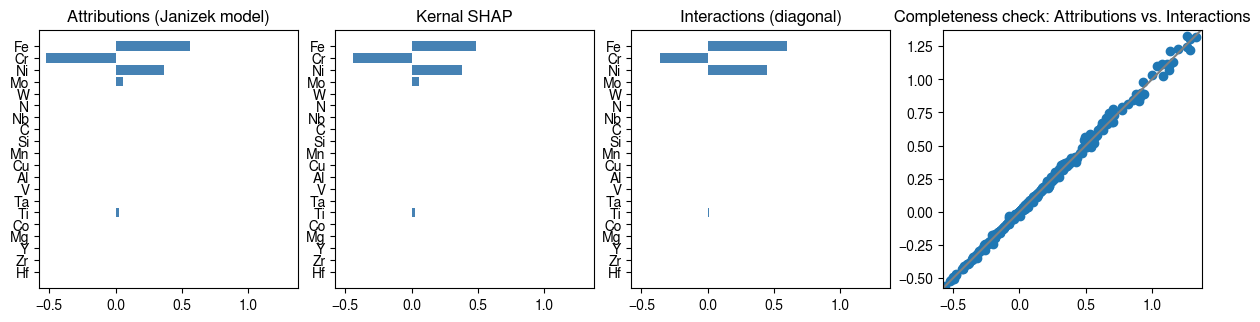

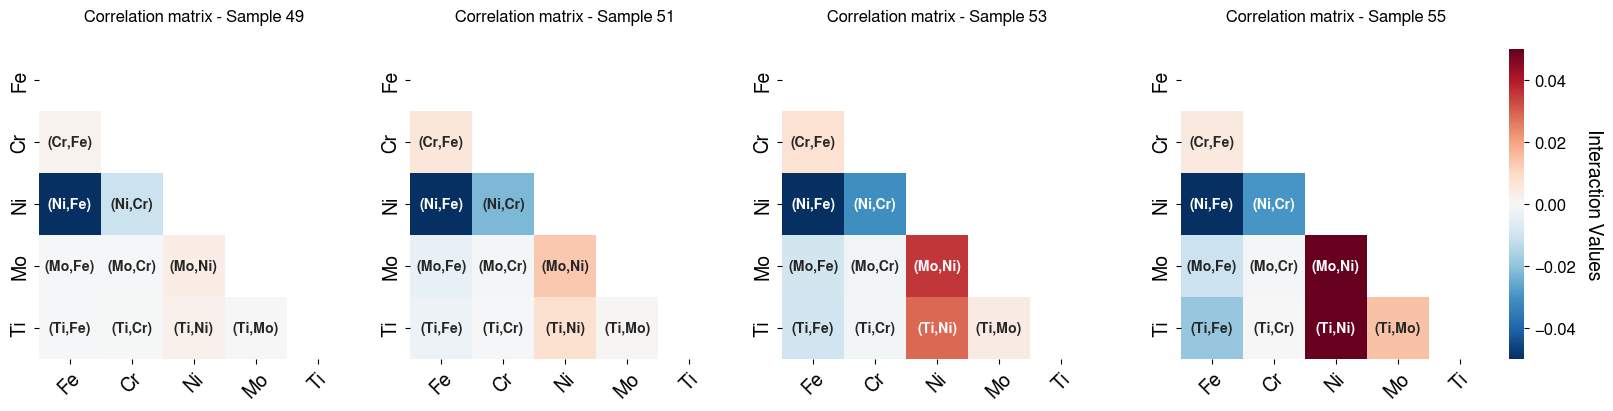

In [33]:
if Flag_Explainer:
    from utils.postprocessing_explainer import plot_shap_attributions_interactions, plot_interactions_heatmap

    sample_index = 0
    plot_shap_attributions_interactions(
        shap_values, attributions_values, interactions_values, sample_index, compo_column)

    sample_index = [49, 51, 53, 55]
    sample_index = [x-1 for x in sample_index]
    plot_interactions_heatmap(
        model_path_bo, interactions_values, sample_index, compo_column,
        cmap='RdBu_r', vmin=-0.05, vmax=0.05, figsize=4,
        save_flag=False, figname='compo_XAI_swish_'+shap_fname+'_interaction')

### Feature attribution/interaction: full ensemble using `ModelExplainer`


In [34]:
if Flag_Explainer:
    from utils.postprocessing_explainer import ModelExplainer

    def run_model_explainers(model_path_bo, model_suffix, scalers, data_lists, k_folds=6, n_CVrepeats=2, mc_repeat=1):

        model_suffix, (iscompo_testing, iscompoOnly, iscompo_features) = next(
            iter(model_suffix_config.items()))
        NNH_model_name = f'NNH_model_RepeatedKFold_{{}}{model_suffix}.h5'
        NNC_model_name = f'NNC_model_RepeatedKFold_{{}}{model_suffix}.h5'
        print('Model used: ',  NNH_model_name)

        repeat_val = k_folds * n_CVrepeats

        X1_base_list, Y1_base_list, V1_base_list, \
            X2_base_list, Z2_base_list, W2_base_list, \
            X1_shap_list, Y1_shap_list, V1_shap_list, \
            X2_shap_list, Z2_shap_list, W2_shap_list = [
                [data]*repeat_val for data in data_lists]

        # Create ModelExplainer instances
        NNH_predictor = ModelExplainer(model_path_bo, NNH_model_name, k_folds, n_CVrepeats, mc_repeat,
                                       scalers["compo"], scalers["H_specific_testing"], scalers["specific_features"])

        NNC_predictor = ModelExplainer(model_path_bo, NNC_model_name, k_folds, n_CVrepeats, mc_repeat,
                                       scalers["compo"], scalers["C_specific_testing"], scalers["specific_features"])

        # Concurrently run ModelExplainer instances
        with concurrent.futures.ThreadPoolExecutor() as executor:
            future1 = executor.submit(NNH_predictor.predict_norm_shap_bootstrap,
                                      X1_base_list, Y1_base_list, V1_base_list,
                                      X1_shap_list, Y1_shap_list, V1_shap_list)

            future2 = executor.submit(NNC_predictor.predict_norm_shap_bootstrap,
                                      X2_base_list, Z2_base_list, W2_base_list,
                                      X2_shap_list, Z2_shap_list, W2_shap_list)

            NNH_explainer_results = future1.result()
            NNC_explainer_results = future2.result()

        return NNH_explainer_results, NNC_explainer_results

    # ----------------------------------------------------------------
    data_lists = [X1_base_data, Y1_base_data, V1_base_data,
                  X2_base_data, Z2_base_data, W2_base_data,
                  X1_shap_data, Y1_shap_data, V1_shap_data,
                  X2_shap_data, Z2_shap_data, W2_shap_data]

    NNH_explainer_results, NNC_explainer_results = run_model_explainers(model_path_bo, model_suffix, scalers,
                                                                        data_lists, k_folds=6, n_CVrepeats=2, mc_repeat=1)

    (H1_pred_norm_X1_base_stack, _, _,
     H1_pred_norm_X1_shap_stack, _, _,
     H1_shap_norm_X1_stack,
     H1_attributions_norm_X1_stack,
     H1_interactions_norm_X1_stack) = NNH_explainer_results

    (C2_pred_norm_X2_base_stack, _, _,
     C2_pred_norm_X2_shap_stack, _, _,
     C2_shap_norm_X2_stack,
     C2_attributions_norm_X2_stack,
     C2_interactions_norm_X2_stack) = NNC_explainer_results

Model used:  NNH_model_RepeatedKFold_{}_compo_XAI_swish.h5


100%|██████████| 69/69 [03:29<00:00,  3.03s/it]


Sum of Shapley values for sample 0: 0.5106079613343659
Sum of attributions for sample 0: 0.5209009721875191
Sum of interactions for sample 0: 0.5248724876930502


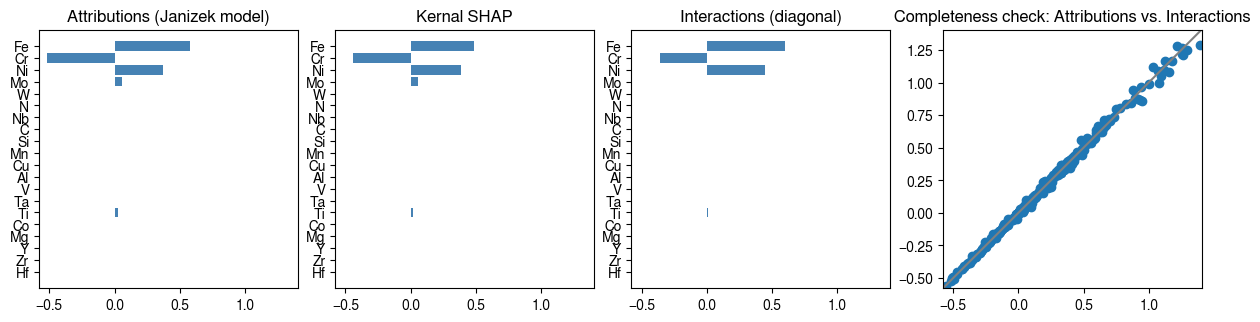

In [35]:
if Flag_Explainer:
    # checking the full dataset - before averaging
    i_KFold, i_sample = 0, 0
    plot_shap_attributions_interactions(
        H1_shap_norm_X1_stack[i_KFold],
        H1_attributions_norm_X1_stack[i_KFold],
        H1_interactions_norm_X1_stack[i_KFold],
        i_sample,
        compo_column)

##### Inverse transfrom feature attribution/interaction index


In [36]:
if Flag_Explainer:
    from utils.postprocessing_explainer import process_inverse_norm_explainer_data

    (H1_pred_norm_X1_base_KFold_mean,
     H1_pred_norm_X1_shap_KFold_mean,
     H1_shap_norm_X1_KFold_mean,
     H1_attributions_norm_X1_KFold_mean,
     H1_interactions_norm_X1_KFold_mean,
     H1_pred_X1_base_KFold_mean,
     H1_pred_X1_shap_KFold_mean,
     H1_shap_X1_KFold_mean,
     H1_attributions_X1_KFold_mean,
     H1_interactions_X1_KFold_mean) = process_inverse_norm_explainer_data(H1_pred_norm_X1_base_stack, H1_pred_norm_X1_shap_stack,
                                                                          H1_shap_norm_X1_stack,
                                                                          H1_attributions_norm_X1_stack,
                                                                          H1_interactions_norm_X1_stack,
                                                                          scalers["H_output"])

    (C2_pred_norm_X2_base_KFold_mean,
     C2_pred_norm_X2_shap_KFold_mean,
     C2_shap_norm_X2_KFold_mean,
     C2_attributions_norm_X2_KFold_mean,
     C2_interactions_norm_X2_KFold_mean,
     C2_pred_X2_base_KFold_mean,
     C2_pred_X2_shap_KFold_mean,
     C2_shap_X2_KFold_mean,
     C2_attributions_X2_KFold_mean,
     C2_interactions_X2_KFold_mean) = process_inverse_norm_explainer_data(C2_pred_norm_X2_base_stack, C2_pred_norm_X2_shap_stack,
                                                                          C2_shap_norm_X2_stack,
                                                                          C2_attributions_norm_X2_stack,
                                                                          C2_interactions_norm_X2_stack,
                                                                          scalers["C_output"])

    # print(H1_pred_X1_shap_KFold_mean.shape)

Sum of Shapley values for sample 0: 81.668701171875
Sum of attributions for sample 0: 83.28867536267117
Sum of interactions for sample 0: 85.73349176091054


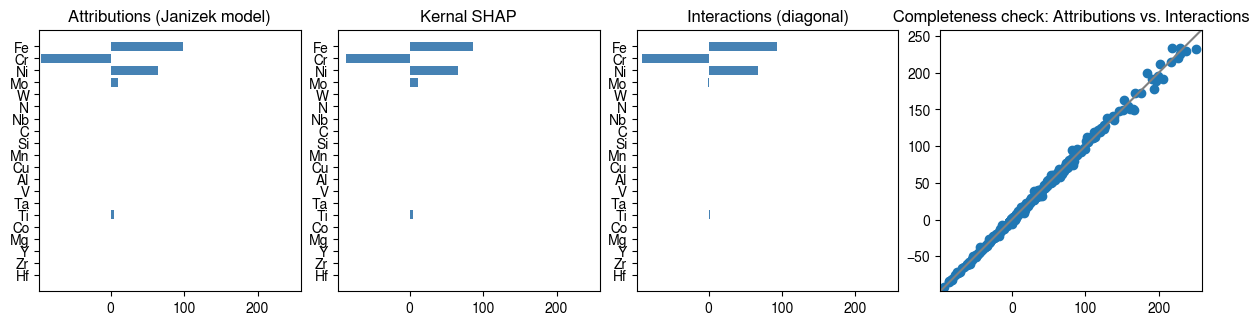

In [37]:
if Flag_Explainer:

    sample_index = 0
    plot_shap_attributions_interactions(
        H1_shap_X1_KFold_mean,
        H1_attributions_X1_KFold_mean,
        H1_interactions_X1_KFold_mean,
        sample_index, compo_column)

#### Force plot of feature Shapley attributions


In [38]:
import shap
from utils.postprocessing_explainer import data_for_shap_force
from IPython.display import display

shap.initjs()
sample_indices = [49, 51, 53, 55]
sample_indices = [x-1 for x in sample_indices]

for sample_index in sample_indices:
    A_baseline, B_shap_values, C_column_names = data_for_shap_force(X1_shap_data, Y1_shap_data, V1_shap_data,
                                                                    compo_column, C_specific_testing_column, specific_features_sel_column,
                                                                    H1_pred_X1_base_KFold_mean, H1_shap_X1_KFold_mean,
                                                                    sample_index=[sample_index])
    # shap.initjs()
    shap_html = shap.force_plot(
        A_baseline,
        B_shap_values,
        C_column_names,
        link='identity',
        matplotlib=False,
        figsize=(5, 2.6),
        text_rotation=45,
        contribution_threshold=0.1)

    display(shap_html)  # Display the plot in th
    shap.save_html(
        model_path_bo + f"shap_force_{shap_fname}_NNH_{sample_index+1}.html", shap_html)

,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,Cu,Al,V,Ta,Ti,Co,Mg,Y,Zr,Hf
0,-7.499479,-17.504636,25.685381,-1.808498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.663426,0.0,0.0,0.0,0.0,0.0


,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,Cu,Al,V,Ta,Ti,Co,Mg,Y,Zr,Hf
0,-21.671167,-22.856432,59.26603,-0.664814,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.052131,0.0,0.0,0.0,0.0,0.0


,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,Cu,Al,V,Ta,Ti,Co,Mg,Y,Zr,Hf
0,-30.703998,-26.510911,100.544501,4.368211,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.081035,0.0,0.0,0.0,0.0,0.0


,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,Cu,Al,V,Ta,Ti,Co,Mg,Y,Zr,Hf
0,-29.646588,-26.960694,149.256453,14.935578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.316832,0.0,0.0,0.0,0.0,0.0


#### Interaction plot


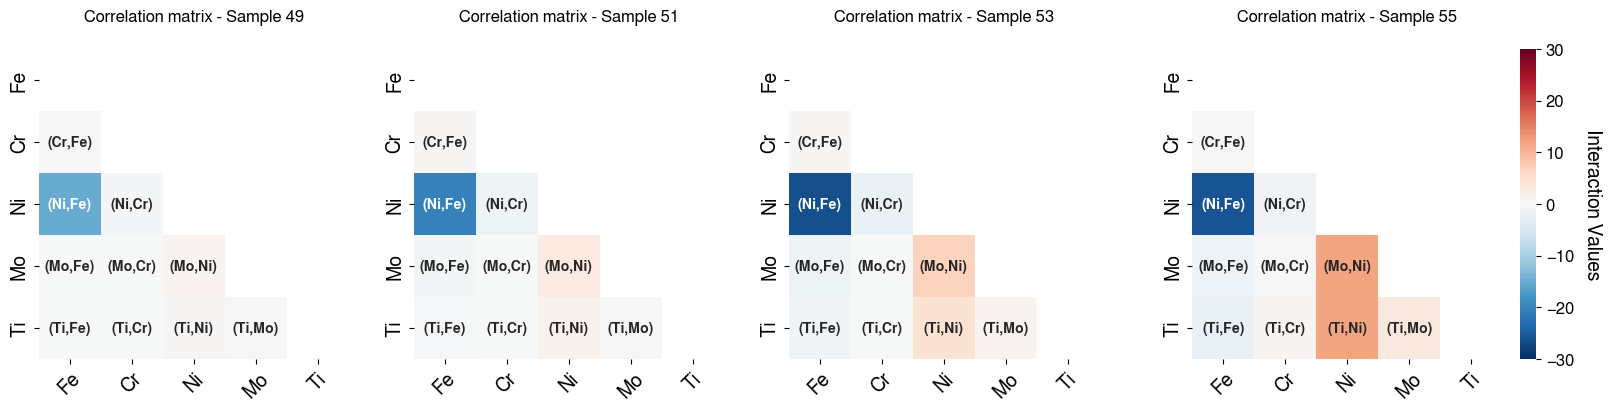

In [39]:
sample_index = [49, 51, 53, 55]
sample_index = [x-1 for x in sample_index]
plot_interactions_heatmap(
    model_path_bo, H1_interactions_X1_KFold_mean, sample_index, compo_column,
    cmap='RdBu_r', vmin=-30, vmax=30, figsize=4,
    save_flag=True, figname='compo_XAI_swish_'+shap_fname+'_NNH_interaction')

### Now use both compositional and engineered features


In [40]:
# if Flag_Explainer:
#     # Specify the model
#     model_suffix_config = {
#         # '_mc_shared_relu': (False, False, False),
#         # '_mc_separate_relu': (False, False, False),
#         # '_mc_NoEng_relu': (True, False, False),
#         # '_compo_XAI_swish': (False, True, False),
#         '_compo_features_XAI_swish': (False, False, True),
#     }

#     # Specify the feature conditions
#     base_fname = 'NiFe_CrMoTi_TC'
#     shap_fname = 'NiCrMoTiFe_KW131'

#     (X1_base_data, Y1_base_data, V1_base_data,
#      X2_base_data, Z2_base_data, W2_base_data,
#      X1_shap_data, Y1_shap_data, V1_shap_data,
#      X2_shap_data, Z2_shap_data, W2_shap_data) = process_base_shap_data(model_suffix_config, base_fname, shap_fname)

Model used:  NNH_model_RepeatedKFold_{}_compo_features_XAI_swish.h5


Processing:   0%|          | 0/14 [00:00<?, ?it/s]

NiCrMoTiFe_KW131 : NiCrMoTiFe_KW131 ['Ni', 'Cr', 'Mo', 'Ti', 'Fe']


Processing:  14%|█▍        | 2/14 [00:01<00:10,  1.14it/s]

NiFe_CrMoTi_TC : NiFe_CrMoTi_TC ['Ni', 'Cr', 'Mo', 'Ti', 'Fe']


Processing: 100%|██████████| 14/14 [00:02<00:00,  5.79it/s]


In [41]:
# if Flag_Explainer:
#     data_lists = [X1_base_data, Y1_base_data, V1_base_data,
#                   X2_base_data, Z2_base_data, W2_base_data,
#                   X1_shap_data, Y1_shap_data, V1_shap_data,
#                   X2_shap_data, Z2_shap_data, W2_shap_data]

#     NNH_explainer_results, NNC_explainer_results = run_model_explainers(model_path_bo, model_suffix, scalers,
#                                                                         data_lists, k_folds=6, n_CVrepeats=2, mc_repeat=1)

#     (H1_pred_norm_X1_base_stack, _, _,
#      H1_pred_norm_X1_shap_stack, _, _,
#      H1_shap_norm_X1_stack,
#      H1_attributions_norm_X1_stack,
#      H1_interactions_norm_X1_stack) = NNH_explainer_results

#     (C2_pred_norm_X2_base_stack, _, _,
#      C2_pred_norm_X2_shap_stack, _, _,
#      C2_shap_norm_X2_stack,
#      C2_attributions_norm_X2_stack,
#      C2_interactions_norm_X2_stack) = NNC_explainer_results

Model used:  NNH_model_RepeatedKFold_{}_compo_features_XAI_swish.h5


100%|██████████| 69/69 [03:49<00:00,  3.33s/it]


In [42]:
# if Flag_Explainer:
#     (H1_pred_norm_X1_base_KFold_mean,
#      H1_pred_norm_X1_shap_KFold_mean,
#      H1_shap_norm_X1_KFold_mean,
#      H1_attributions_norm_X1_KFold_mean,
#      H1_interactions_norm_X1_KFold_mean,
#      H1_pred_X1_base_KFold_mean,
#      H1_pred_X1_shap_KFold_mean,
#      H1_shap_X1_KFold_mean,
#      H1_attributions_X1_KFold_mean,
#      H1_interactions_X1_KFold_mean) = process_inverse_norm_explainer_data(H1_pred_norm_X1_base_stack, H1_pred_norm_X1_shap_stack,
#                                                                           H1_shap_norm_X1_stack,
#                                                                           H1_attributions_norm_X1_stack,
#                                                                           H1_interactions_norm_X1_stack,
#                                                                           scalers["H_output"])

#     (C2_pred_norm_X2_base_KFold_mean,
#      C2_pred_norm_X2_shap_KFold_mean,
#      C2_shap_norm_X2_KFold_mean,
#      C2_attributions_norm_X2_KFold_mean,
#      C2_interactions_norm_X2_KFold_mean,
#      C2_pred_X2_base_KFold_mean,
#      C2_pred_X2_shap_KFold_mean,
#      C2_shap_X2_KFold_mean,
#      C2_attributions_X2_KFold_mean,
#      C2_interactions_X2_KFold_mean) = process_inverse_norm_explainer_data(C2_pred_norm_X2_base_stack, C2_pred_norm_X2_shap_stack,
#                                                                           C2_shap_norm_X2_stack,
#                                                                           C2_attributions_norm_X2_stack,
#                                                                           C2_interactions_norm_X2_stack,
#                                                                           scalers["C_output"])

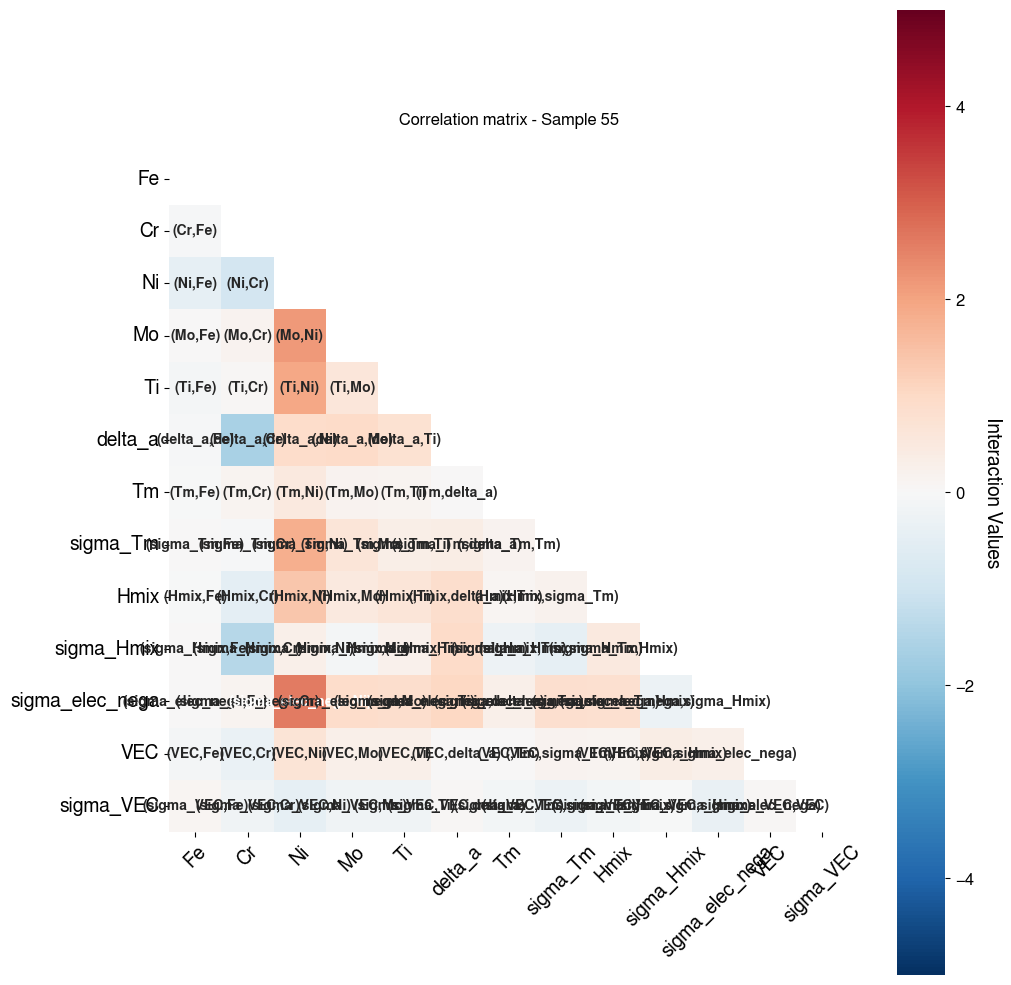

In [45]:
# if Flag_Explainer:
#     # sample_index = [49, 51, 53, 55]
#     sample_index = [55]
#     sample_index = [x-1 for x in sample_index]
#     plot_interactions_heatmap(
#         model_path_bo, H1_interactions_X1_KFold_mean, sample_index, compo_column +
#         specific_features_sel_column,
#         cmap='RdBu_r', vmin=-5, vmax=5, figsize=10,
#         save_flag=False, figname='compo_XAI_swish_'+shap_fname+'_NNH_interaction')